### TODO
1. ~~Code up VAE~~
2. ~~Code up M (RNN)~~
3. ~~Code up Train Loop for M~~
3. ~~Code up C (Controller)~~
4. ~~Set up Car Racing data for C~~
5. ~~set up car racing rollouts for VAE~~
6. ~~add in nice way to save weights and rollouts in same dir for VAE~~
6. add train loop for C
7. Get C working with VAE weights
6. set up VAE data with MDN_RNN
7. add temperature to MDN-RNN
8. add model saving to MDN-RNN
9. Get C working with VAE, MDN_RNN weights
10. do on atari
11. code up baseline -> simple dqn-like thing
12. add weight init
13. disentangling

In [1]:
import gym
import matplotlib.pyplot as plt
import torch
# setup rendering before importing other stuff (weird hack to avoid pyglet errors)
env = gym.make("CarRacing-v0")
_ = env.reset()
_ = env.render("rgb_array")
import numpy as np
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn import init
from torch import optim
import time
from copy import deepcopy
from tqdm import tqdm


import os
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
import sys

if "ipykernel_launcher" in sys.argv[0]:
    sys.argv = [""]
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--vae_weights",type=str,default="/data/milatmp1/racaheva/models/vae_lr=0.001_rollouts=1000_batch_size=128_opt=adam/currVAE.pth")
parser.add_argument("--popsize",type=int,default=5) #64 in paper
parser.add_argument("--rollouts_per_solution",type=int,default=5) # 16 in paper

args = parser.parse_args()
import cma
from vae import VAE
from torchvision.transforms import Compose,Normalize,Resize,ToTensor
from torch.utils.data import DataLoader, Dataset
from PIL import Image


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Track generation: 1304..1643 -> 339-tiles track
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Track generation: 1095..1373 -> 278-tiles track


In [2]:
def show_envs(key=""):
    aenv = envs.registry.all()
    all_envs = str(aenv).replace("EnvSpec","").replace("dict_values", "").replace("(","").replace(")","").replace("[","").replace("]","").split(", ")
    for env in all_envs:
        if key == "":
            print(env)
        else:
            if key in env:
                print(env)

In [3]:

def display_frames_as_gif(frames,save=False):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if save:
        anim.save('./hey.gif', writer='imagemagick', fps=60)

    display(display_animation(anim, default_mode='loop'))

In [4]:
class C(nn.Module):
    def __init__(self,parameters=None,env="CarRacing"):
        super(C,self).__init__()
        if env == "CarRacing":
            self.nz = 32
            self.nh = 256
            self.action_len = 3 
        
        self.fc = nn.Linear(in_features=self.nz,out_features=self.action_len)
        if parameters is not None:
            weight_len = np.prod(self.fc.weight.size())
            weight = parameters[:weight_len]
            weight = np.resize(weight,self.fc.weight.size())
            bias = parameters[weight_len:]
            bias = np.resize(bias,self.fc.bias.size())
            self.fc.weight.set_(Variable(torch.from_numpy(weight).float()))
            self.fc.bias.set_(Variable(torch.from_numpy(bias).float()))
    
    def posprocess_output(self,raw_output):
        raw_steer, raw_gas, raw_brake = raw_output[0],raw_output[1],raw_output[2]

        steer = F.tanh(raw_steer) # between -1 and 1

        gas = F.softplus(raw_gas) # between 0 and 1

        brake = F.softplus(raw_brake) # between 0 and 1
        return steer,gas,brake
        
    
    def forward(self,z):
        z = z.squeeze()
        #h = h.squeeze()
        #zh = torch.cat((z,h),dim=-1)
        raw_output = self.fc(z)
        steer, gas, brake = self.posprocess_output(raw_output)
        action = torch.cat((steer,gas,brake))
        return action.data
        

In [5]:
def convert_frame(state):
    state = Image.fromarray(state, 'RGB')

    transforms = Compose([Resize((64,64)),ToTensor()])

    state = transforms(state)

    state = Variable(state).cuda()
    return state

In [6]:


batch_size=1
seq_len=1
env_name = "CarRacing-v0"
def evaluate(parameters,env_name="CarRacing-v0",verbose=False, rollouts_per_solution=args.rollouts_per_solution):
    c = C(parameters=parameters).cuda()
    env = gym.make(env_name)
    done = False
    solution_rewards = [] 
    for _ in range(rollouts_per_solution):
        s = env.render("rgb_array")
        state = env.reset()
        
        reward_sum = 0.
        while not done:
            state = convert_frame(state)
            _,_,_,z = V(state[None,:])
            #h = Variable(torch.Tensor(seq_len,1,batch_size,c.nh).normal_()).cuda()
            a = c(z)
            state,reward,done,_ = env.step(a)
            reward_sum += reward
        solution_rewards.append(reward_sum)
    if verbose:
        return np.mean(solution_rewards), solution_rewards
    else:    
        return np.mean(solution_rewards)
        
 
    

In [7]:
V = VAE().cuda()

V.load_state_dict(torch.load(args.vae_weights))


w0 = np.random.randn((3*32))
b0 = np.random.randn(3,)
p0 = np.concatenate((w0,b0))

sig0 = np.eye(p0.shape[0])

solver = cma.CMAEvolutionStrategy(x0=p0,
                                  sigma0=1,
                                  inopts={"popsize":args.popsize})

MY_REQUIRED_FITNESS = -20.
it = 0
while True:

    # ask the ES to give us a set of candidate solutions
    solutions = solver.ask()

    # create an array to hold the fitness results.
    fitness_list = np.zeros(solver.popsize)

    # evaluate the fitness for each given solution.
    for i in range(solver.popsize):
        fitness_list[i] = evaluate(solutions[i])

    # give list of fitness results back to ES
    solver.tell(solutions,fitness_list)

    # get best parameter, fitness from ES
    best_solution, best_fitness, *others = solver.result

    print(best_fitness)
    if best_fitness > MY_REQUIRED_FITNESS:
        break
    it +=1
    

(2_w,5mirr1)-aCMA-ES (mu_w=1.6,w_1=73%) in dimension 99 (seed=687390, Tue Apr 24 15:33:19 2018)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Track generation: 1096..1374 -> 278-tiles track
Track generation: 1091..1374 -> 283-tiles track
Track generation: 971..1218 -> 247-tiles track
Track generation: 1131..1418 -> 287-tiles track
Track generation: 1164..1459 -> 295-tiles track
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Track generation: 1245..1560 -> 315-tiles track
Track generation: 1078..1354 -> 276-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 914..1150 -> 236-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1215..1523 -> 308-tiles track
Track generation: 1019..1278 -> 259-tiles track
Track generation: 1089..1368 -> 279-tiles track
retry to generate track (normal if t

In [11]:
avg_rew, rew_dist = evaluate(best_solution,env_name="CarRacing-v0",verbose=True, rollouts_per_solution=100)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Track generation: 1144..1441 -> 297-tiles track
Track generation: 1430..1800 -> 370-tiles track
Track generation: 1176..1474 -> 298-tiles track
Track generation: 1087..1363 -> 276-tiles track
Track generation: 1123..1408 -> 285-tiles track
Track generation: 1001..1264 -> 263-tiles track
Track generation: 920..1159 -> 239-tiles track
Track generation: 1171..1468 -> 297-tiles track
Track generation: 1318..1652 -> 334-tiles track
Track generation: 1093..1374 -> 281-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1156..1449 -> 293-tiles track
Track generation: 1140..1429 -> 289-tiles track
Track generation: 1186..1494 -> 308-tiles track
Track generation: 1248..1564 -> 316-tiles track
Track generation: 1123..1413 -> 290-tiles track
Track generation: 1116..1403 -> 287-tiles track
retry to generate track (normal if there are not many of this 

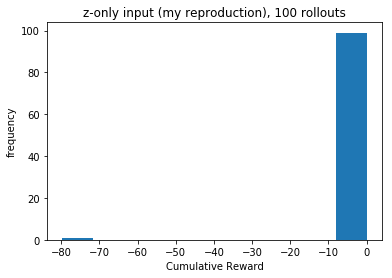

In [17]:
plt.hist(rew_dist)
plt.xlabel("Cumulative Reward")
plt.ylabel("frequency")
plt.title("z-only input (my reproduction), 100 rollouts")
plt.show()
